In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from gen_mat import *
from block_rect_maxvol import *
import re
import os
from matplotlib import cm
%matplotlib inline

In [4]:
num_expr = 1 # Adding this num to output fn for distinguish between experiments
nder = 2 # Dimension
ToLoadSet = False
functions = [rosenbrock, sincos, roots, gauss]
inital_points_distribs = ['random', 'LHS']

if ToLoadSet:
    from sandbox_bm_approx_settings import *
else:
    dir_str = '.'
    num_points_for_big_matrix = 100 # number of points for big matrix
    max_row = 10                      # Maximum number of points taken in experiments
    max_expansion = 6                 # number of columns in big matrix in (nder+1) units
    min_expansion = 1                 # minimal number of columns in experiments in (nder+1) units
    

    n_test = 5000    # points on test grid (for calculating error on final step)
    poly = cheb       # used polinomials


#####
dir_pdf = os.path.join(dir_str, "pdf")
try:
    os.mkdir(dir_pdf)
except:
    pass



ToTakePointsFromFile = False

# ---------------------------------
p_size = (nder+1)*max_row #number of rows in big matrix
# x = 2*np.random.rand(num_points_for_big_matrix, nder) - 1

### generating test points
points_test = test_points_gen(n_test, nder, distrib='random') 


#contents of file sandbox_bm_approx_settings.py
_="""
from gen_mat import cheb


dir_str = '.'
num_points_for_big_matrix = 50000 # number of points for big matrix
max_row = 50                      # Maximum number of points taken in experiments
max_expansion = 10                 # number of columns in big matrix in (nder+1) units
min_expansion = 1                 # minimal number of columns in experiments in (nder+1) units

n_test = 50000    # points on test grid (for calculating error on final step)
poly = cheb       # used polynomials
"""

### Testing the new most general environment

In [5]:
### evaluating test
for inital_points_distrib in inital_points_distribs:
    points_fn = 'taken_points_{}'.format(inital_points_distrib)
    x = test_points_gen(num_points_for_big_matrix, nder, distrib=inital_points_distrib)
    
    A = GenMat(p_size, x, poly=poly, debug=False, pow_p=1)
    A = matrix_prep(A, nder+1, num_points_for_big_matrix)
    
    np.savez(os.path.join(dir_str, points_fn), x=x, points_test=points_test)
    
    fn_pre = lambda function : "func={}_poly={}_distrib={}".format(function.__name__, poly.__name__, inital_points_distrib)
    fls = [open(os.path.join(dir_str, fn_pre(function) + '.txt'), "w") for function in functions]
    
    fn_pre_pdf = "poly={}_distrib={}".format(poly.__name__, inital_points_distrib)
    for expansion in range(min_expansion, max_expansion):
                for N_rows_ex in range(max_row, expansion, -1): # It's not the way people do...
                    N_rows = N_rows_ex*(nder+1)
                    fnpdf = os.path.join(dir_pdf, fn_pre_pdf + "_expansion={}_N_rows_ex={}.pdf".format(expansion, N_rows_ex))
                    try:
                        error, taken_points = test(A, x, points_test, nder, expansion, N_rows, functions, 
                                                   poly=poly, to_save_pivs=N_rows_ex==max_row, 
                                                   fnpdf=fnpdf)
                    except SingularError as err:
                        print ('not full column rank with expansion={}, N_rows_ex={}, err={}'.format(
                                                            expansion, N_rows_ex, err.value)) 
                        #continue
                        break

                    for i, f in enumerate(fls):
                        taken_points.tofile(f, sep=" ")
                        f.write("_error={}_Nrows={}_expans={}\n".format(error[i], N_rows, expansion))
                        f.flush()
                    
    for f in fls:
        f.close()


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numba/dataflow.py:379: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)
block_rect_maxvol.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_block, res_x, rank, s = np.linalg.lstsq(M[cut_piv], block_func_deriv)


not full column rank with expansion=2, N_rows_ex=10, err=2
not full column rank with expansion=5, N_rows_ex=10, err=2
not full column rank with expansion=2, N_rows_ex=10, err=2


In [6]:
def file_extraction(Filepath):
    srch = re.compile(r'([\d\s]+)_error=([\+\-\d\.eE]+)_Nrows=(\d+)_expans=(\d+)')
    fnd = srch.findall(open(Filepath, 'r').read())
    return tuple(np.array(i) for i in zip(*[(float(i0), int(i1), int(i2), [int(p) for p in im1.strip().split(' ') if len(p) > 0])
                                            for im1, i0, i1, i2 in fnd]))


def DataToMesh(error, N_row, N_col, *args):
    row_s = sorted(list(set(N_row)))
    col_s = sorted(list(set(N_col)))
    data = {(N_row[i], N_col[i]) : e for i, e in enumerate(error)}
    
    res = np.empty((len(row_s), len(col_s)), dtype=float)
    for i, r in enumerate(row_s):
        for j, c in enumerate(col_s):
            try:
                res[i,j] = data[(r, c)]
            except:
                res[i,j] = np.nan
    X, Y = np.meshgrid(row_s, col_s)
    return res.T, X, Y

def PlotError(fn, log_it=False):
    error, N_row, N_col = DataToMesh(*file_extraction(fn))
    if log_it:
        error = np.log10(error)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(N_row, N_col, error, edgecolor='black', linewidth=0.5, cmap = cm.Spectral)
    # ax.legend()
    ax.set_xlabel('N_rows', fontsize=10)
    ax.set_ylabel('N_columns')
    plt.show()
    
    
# Not used
def PlotPoints(fn, row, col, x, to_save_fig=False, fn_out="func.pdf"):
    _, N_row, N_col, idx = file_extraction(fn)
    
    l_bound = np.amin(x, 0)
    u_bound = np.amax(x, 0)
    delta = (u_bound - l_bound)/20.0
    plt.xlim(l_bound[0] - delta[0], u_bound[0] + delta[0])
    plt.ylim(l_bound[1] - delta[1], u_bound[1] + delta[1])
    plt.plot(x[idx, 0], x[idx, 1], 'b^')
    # plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
    # plt.title("E = {}".format(error))
    plt.grid(True)
    if to_save_fig:
        # fn = 'func={}_d={}_num={}_nder={}.pdf'.format(function.__name__, N_column, N_rows, nder)
        plt.savefig(fn_out)
    

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


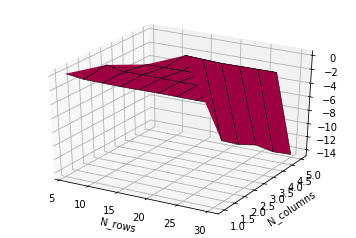

In [7]:
PlotError("func=Rosenbrock_poly=cheb.txt", True)